In [1]:
import netCDF4
from osgeo import gdal
from osgeo import osr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import os
import re
import xarray as xr
import rioxarray as rxr


In [2]:
nc_2012_2021 = [x for x in glob.glob("../data/historische_daten/*/*.nc") if re.search(".+201[2-9]|202[0-1]\d{8}", x)]
ds = xr.open_mfdataset(nc_2012_2021)

In [3]:
ds

<xarray.Dataset>
Dimensions:                 (time: 3653, E: 370, N: 240)
Coordinates:
  * E                       (E) float64 2.474e+06 2.476e+06 ... 2.844e+06
  * N                       (N) float64 1.064e+06 1.066e+06 ... 1.304e+06
  * time                    (time) datetime64[ns] 2012-01-01 ... 2021-12-31
    lon                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
    lat                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
Data variables:
    swiss_lv95_coordinates  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TabsD                   (time, N, E) float32 dask.array<chunksize=(366, 240, 370), meta=np.ndarray>
    TmaxD                   (time, N, E) float32 dask.array<chunksize=(366, 240, 370), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...

In [4]:
# what dimensions does the netCDF file have?
ds.dims

# the shape of lon 370 cells (each **1**km) east-west, looks correct
# the shape of lat 240 cells (each **1**km) north-south, looks correct
# the shape of time 3'653 days, looks correct (10 years of daily data)

Frozen({'time': 3653, 'E': 370, 'N': 240})

In [5]:
# What variables does the dataset have?
ds.coords

Coordinates:
  * E        (E) float64 2.474e+06 2.476e+06 2.476e+06 ... 2.842e+06 2.844e+06
  * N        (N) float64 1.064e+06 1.066e+06 1.066e+06 ... 1.302e+06 1.304e+06
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2021-12-31
    lon      (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
    lat      (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>

In [6]:
# sadly, not many attributes attached to the dataset
for key, val in ds.attrs.items():
    print("key:",key,"| val:", val, "\n")
    

key: Conventions | val: CF-1.6 

key: institution | val: Federal Office of Meteorology and Climatology MeteoSwiss 

key: References | val: Frei C., 2014: Interpolation of temperatures in a mountainous region using nonlinear profiles and non-Euclidean distances. Int. J. Climatol., 34, 1585-1605. DOI: 10.1002/joc.3786. 



In [7]:
# I can extract a specific range like so:
ds.sel(time = slice("2012-04-01", "2012-09-30"))

<xarray.Dataset>
Dimensions:                 (time: 183, E: 370, N: 240)
Coordinates:
  * E                       (E) float64 2.474e+06 2.476e+06 ... 2.844e+06
  * N                       (N) float64 1.064e+06 1.066e+06 ... 1.304e+06
  * time                    (time) datetime64[ns] 2012-04-01 ... 2012-09-30
    lon                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
    lat                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
Data variables:
    swiss_lv95_coordinates  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TabsD                   (time, N, E) float32 dask.array<chunksize=(183, 240, 370), meta=np.ndarray>
    TmaxD                   (time, N, E) float32 dask.array<chunksize=(183, 240, 370), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...

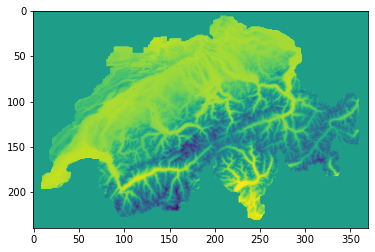

In [8]:
def hugglin(x):
    return (((x.TabsD-10)+(x.TmaxD-10))/2)*1.045

ds_hugg = ds.sel(time = slice("2012-04-01", "2012-09-30")).groupby("time").map(hugglin).sum(dim="time")

plt.imshow(np.flip(ds_hugg, 0))



What I need to calculate is the following (pseudocode):

```
for years in 2012-2021:
    for days in 01.04.year-30.09.year):
        ((tas-10)+(tas_max-10))/2*1.045
        
```

In [9]:
# Import the kanton of luzern ....
kantonsgrenze = gpd.read_file("../data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/", layer = "TLM_KANTONSGEBIET").query("NAME == 'Luzern'") # fiona.listlayers("data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/")

# buffer it with 2km, transform it to wsg84 and get the bounding box
kanton_bounds = kantonsgrenze.buffer(2000).bounds
kanton_bounds

,minx,miny,maxx,maxy
8,2.628130e+06,1.178571e+06,2.683764e+06,1.239690e+06


In [12]:
minx, maxx, miny, maxy = kanton_bounds["minx"].iloc[0], kanton_bounds["maxx"].iloc[0], kanton_bounds["miny"].iloc[0], kanton_bounds["maxy"].iloc[0]


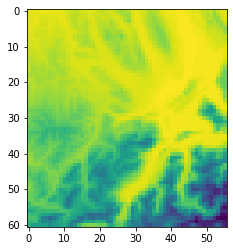

In [13]:
ds_hugg_lu = ds.sel(time = slice("2012-04-01", "2012-09-30"), E = slice(minx, maxx), N = slice(miny, maxy)).groupby("time").map(hugglin).sum(dim="time")

plt.imshow(np.flip(ds_hugg_lu, 0))

In [96]:
all_years = []
datasets = {}
for year in range(2012, 2022):
    print("year",year)
    start = str(year)+"-04-01"
    end = str(year)+"-09-30"
    
    ds_hugg_lu = ds.sel(time = slice(start, end), E = slice(minx, maxx), N = slice(miny, maxy)).groupby("time").map(hugglin).sum(dim="time")
    subdir = "../output/historic/"
    
    os.makedirs(subdir, exist_ok=True)
           
        
    ds_hugg_lu.rio.set_spatial_dims("E", "N", inplace=True)
    ds_hugg_lu.rio.write_crs("epsg:2056", inplace=True)
    
    
    outfilename = subdir+str(year)+".tif"
    ds_hugg_lu.rio.to_raster(outfilename)
            
    all_years.append(ds_hugg_lu)
    datasets[year] = outfilename
    
    ######### for manual control
    if False:
        TmaxD = ds.sel(time = slice(start, end), E = slice(minx, maxx), N = slice(miny, maxy))["TmaxD"].mean(dim = "time")
        TabsD = ds.sel(time = slice(start, end), E = slice(minx, maxx), N = slice(miny, maxy))["TabsD"].mean(dim = "time")

        TmaxD.rio.set_spatial_dims("E", "N").rio.write_crs("epsg:2056").rio.to_raster(subdir+str(year)+"_Tmax_mean.tif")
        TabsD.rio.set_spatial_dims("E", "N").rio.write_crs("epsg:2056").rio.to_raster(subdir+str(year)+"_Tabs_mean.tif")
    
       
    #############################
         
    
all_years = xr.concat(all_years, "time").mean(dim = "time")
all_years.rio.set_spatial_dims("E", "N", inplace=True)
all_years.rio.write_crs("epsg:2056", inplace=True)
all_years.rio.to_raster(subdir+"Mean.tif")




year 2012


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2013


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2014


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2015


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2016


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2017


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2018


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2019


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2020


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


year 2021


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


Example: Year 2012

- Mean of Tabs: 13°C
- Mean of Tmax: 17°C
- $((13-10)+(17-10))/2*1.045= 5.225$
- 5.225 HI per day, for 183 days (1.4. - 30.09): 956 (expected value)
- Mean of dataset: 1'058






In [89]:
%%bash
for i in c d; 
    do for j in a b; 
        do echo $i $j; 
    done; 
done

c a
c b
d a
d b
